## Preprocessing

In [20]:
## Packages
##Imports
import pandas as pd
import transformers
import openpyxl
import numpy
import torch

In [21]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [22]:
torch.cuda.is_available()

True

In [23]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Ti'

In [24]:
## Reading in the PSYTar data set and parsing it

## Use sentence_labelling sheet

fileName=".\ONLINE_FORA\PsyTAR_dataset.xlsx"
data=pd.ExcelFile(fileName)
sheets={}
for sheet in data.sheet_names:
    sheets[sheet]=data.parse(sheet)

## Remove the first two sheets (License and read_me)
sheets.pop('License',None)
sheets.pop('read_me',None)

## This will print out the sheet names for the whole excel
for sheet in sheets.keys():
    print(f"Sheet Name: {sheet}")

#To access a sheet, perform sheet['Sheet_Name']; e.g., sheets['Sample']

Sheet Name: Sample
Sheet Name: Sentence_Labeling
Sheet Name: ADR_Identified
Sheet Name: ADR_Mapped
Sheet Name: WD_Identified
Sheet Name: WD-Mapped 
Sheet Name: SSI_Identified
Sheet Name: SSI_Mapped
Sheet Name: DI_Identified
Sheet Name: DI_Mapped


## TFIDF K-Means

In [28]:
## Vectorize data into TF-IDF and preprocess data

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer


def preprocess(text):
    text=str(text)
    tokens=nltk.word_tokenize(text.lower())
    tokens_clean=[t for t in tokens if (t not in stop_words) and (t not in punctuations)]
    return ' '.join(tokens_clean)
    
stop_words=nltk.corpus.stopwords.words('english')
punctuations=string.punctuation

df=data.parse('Sentence_Labeling')
df.drop(df.tail(1).index,inplace=True)
df['drug_id']=df['drug_id'].str.lower()
df['drug_name']=df['drug_id'].str.replace(r'\.\d+','',regex=True)
df['sentences']=df['sentences'].apply(preprocess)
df.fillna(0,inplace=True)
unique_drug_count=df['drug_name'].nunique()

tfidf=TfidfVectorizer()
tfidfSentences=tfidf.fit_transform(df['sentences'])

print(tfidfSentences)

print('Number of Drug Types:',unique_drug_count)
print(df)

## ADR: adverse drug reaction
## WD: withdrawal symptom
## EF: effective
## INF: ineffective
## SSI: Sign/symptom/illness - if report contains explicit SSI that patient experienced that are not a result of the drug
## DI: drug indication - shows SSI that explicitly mentioned as being resolved because of drug consumption

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.6 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   -- ------------------------------------- 0.6/10.6 MB 12.6 MB/s eta 0:00:01
   ---- ----------------------------------- 1.3/10.6 MB 13.7 MB/s eta 0:00:01
   ------- -------------------------------- 2.0/10.6 MB 14.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.5/10.6 MB 14.5 MB/s eta 0:00:01
   ---------- ----------------------------- 2.7/10.6 MB 12.3 MB/s eta 0:00:01
   ------------ --------------------------- 3.4/10.6 MB 12.1 MB/s eta 0:00:01
   --------------- ------------------------ 4.2/10.6 MB 12.6 MB/s eta 0:00:01
   ------------------ --------------------- 4.9/10.6 MB 12.9 MB/s eta 0:00:01
   -------------------- ------------------- 5.5/10.6 MB 13.0 MB/s eta 0:00

In [29]:
## Investigate K-means clustering to see whether certain medicines have different side effects - use as baseline to see if there is a significant difference with the transformer model
from sklearn.cluster import KMeans

vocabulary=tfidf.get_feature_names_out()
print(vocabulary)

num_clusters=4
km = KMeans(n_clusters=num_clusters,random_state=42)
km.fit(tfidfSentences)
top_words=km.cluster_centers_.argsort()
print(vocabulary[top_words])
df['cluster']=km.labels_

['00' '04' '06' ... 'zoning' 'zopiclone' 'zyprexa']
[['00' 'paramedics' 'paralyzing' ... 'though' 'feel' 'even']
 ['easliy' 'snowball' 'smptoms' ... 'depression' 'effects' 'side']
 ['00' 'pantry' 'pant' ... 'side' 'effects' 'drug']
 ['kidney' 'nose' 'notable' ... 'day' 'first' 'taking']]


drug_name
cymbalta     1707
effexorxr    1549
lexapro      1492
zoloft       1261
Name: count, dtype: int64
drug_name  cymbalta  effexorxr  lexapro  zoloft
cluster                                        
0                45         45       23      21
1              1326       1192     1178    1012
2                97        122       55      54
3               239        190      236     174


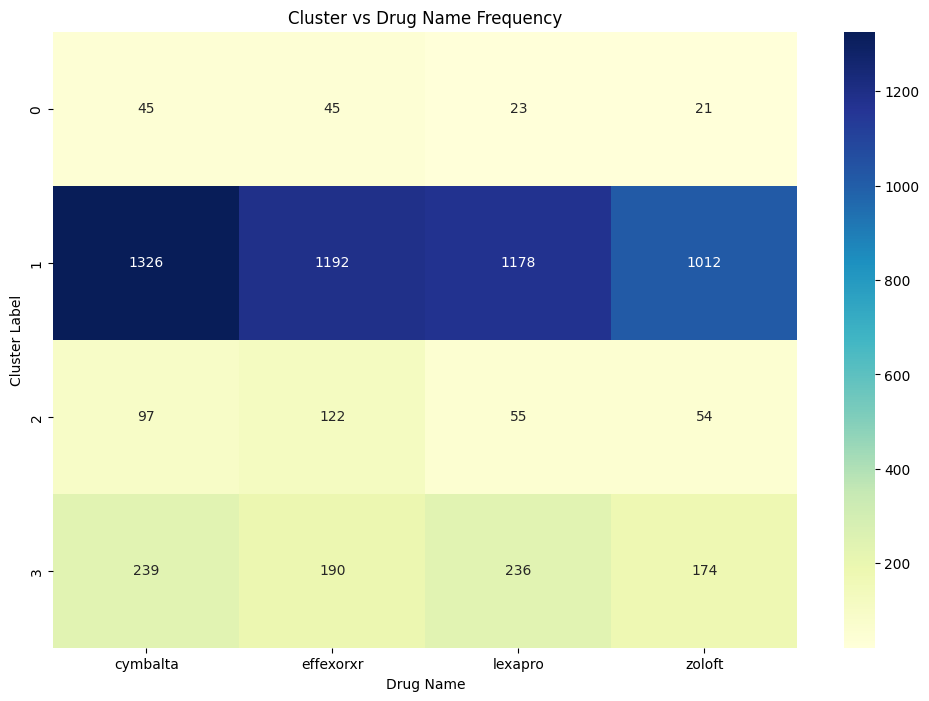

Chi2: 45.95915230961694, p-value: 6.128152407241562e-07


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

print(df['drug_name'].value_counts())

contingency_table = pd.crosstab(df['cluster'], df['drug_name'])
print(contingency_table)

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Cluster vs Drug Name Frequency')
plt.ylabel('Cluster Label')
plt.xlabel('Drug Name')
plt.show()

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p}")

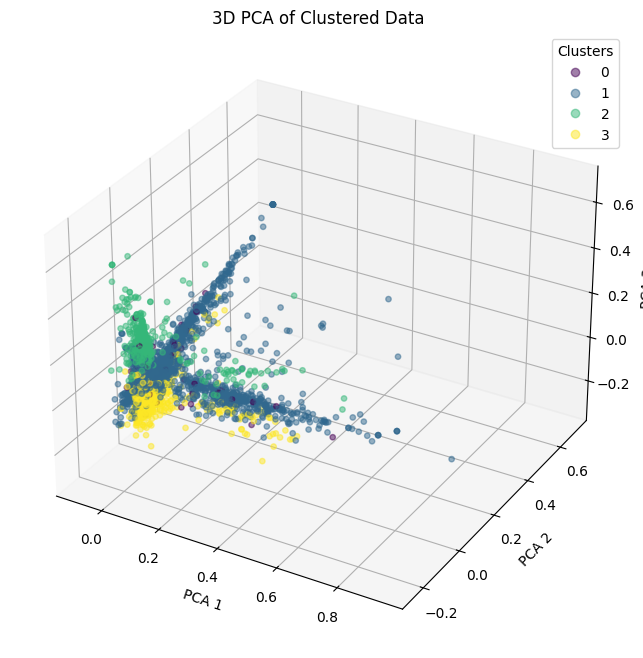

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.cluster import KMeans


pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=km.labels_, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.dist=12
legend = ax.legend(*scatter.legend_elements(), loc='upper right', title="Clusters")

plt.title('3D PCA of Clustered Data')
plt.show()

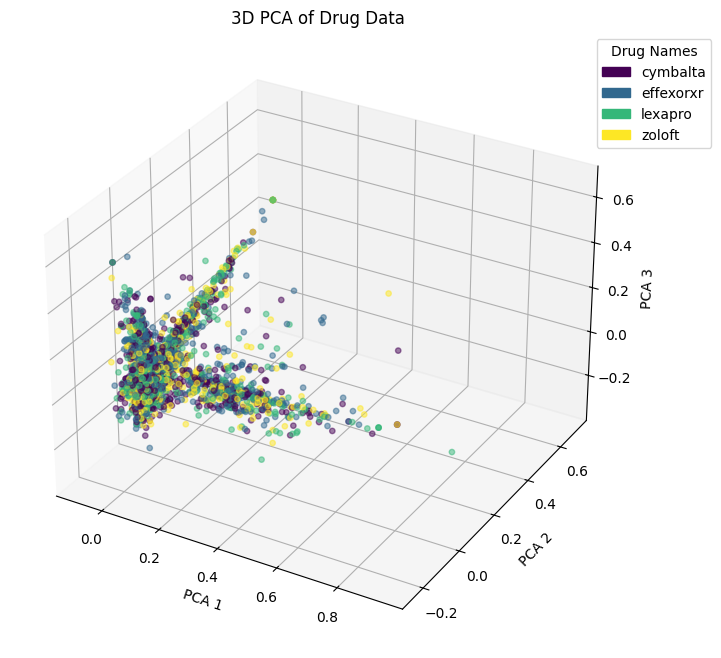

In [34]:
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch
import numpy as np

label_encoder = LabelEncoder()
drug_labels = label_encoder.fit_transform(df['drug_name'])

pca = PCA(n_components=3) 
X_dim = pca.fit_transform(tfidfSentences.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_dim[:, 0], X_dim[:, 1], X_dim[:, 2], c=drug_labels, cmap='viridis', s=15, alpha=0.5)

ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

cmap = plt.cm.viridis

legend_handles = [Patch(color=cmap(norm), label=label) for label, norm in zip(label_encoder.classes_, np.linspace(0, 1, len(label_encoder.classes_)))]
ax.legend(handles=legend_handles, title="Drug Names", loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title('3D PCA of Drug Data')
plt.show()

## Transformer

In [35]:
## Transformers
from sklearn.model_selection import train_test_split

df['DI'] = pd.to_numeric(df['DI'], errors='coerce')

# Features and labels
x = df['sentences'].values
y = df[['ADR', 'WD', 'EF', 'INF', 'SSI', 'DI']].values

# Split data
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.11, random_state=42) 


In [36]:
print('total length=',len(df))
print('%len of training set=',len(x_train)/len(df)*100)
print('%len of validation set=',len(x_val)/len(df)*100)
print('%len of test set=',len(x_test)/len(df)*100)

total length= 6009
%len of training set= 80.09652188384091
%len of validation set= 9.901813945748044
%len of test set= 10.001664170411049


In [37]:
from transformers import AutoTokenizer


max_len=16
train_batch_size=32
dev_batch_size=32
epochs=1
learning_rate=1e-05
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(X):
    return tokenizer(X.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')

x_train_tokenized = tokenize_data(x_train)
x_val_tokenized = tokenize_data(x_val)


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [38]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  # Ensure float dtype
        return item

    def __len__(self):
        return len(self.labels)

# Create dataset instances
train_dataset = TextClassificationDataset(x_train_tokenized, y_train)
val_dataset = TextClassificationDataset(x_val_tokenized, y_val)


In [39]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [40]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6) 


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
print(epochs)

1


In [45]:
from transformers import AdamW
import torch
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}") 

model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
model.train()
for epoch in range(epochs):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': loss.item()})

    print(f"Epoch {epoch+1} completed, Last batch loss: {loss.item()}")


c:\Users\julev\anaconda3\envs\cudaEnv\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Using device: NVIDIA GeForce RTX 3060 Ti


Epoch 1/1:   0%|          | 0/151 [00:00<?, ?it/s]C:\Users\julev\AppData\Local\Temp\ipykernel_13068\1620534317.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1/1: 100%|██████████| 151/151 [00:35<00:00,  4.29it/s, loss=nan]

Epoch 1 completed, Last batch loss: nan
